# Extracting text from wildlife camera videos
In this notebook I use OpenCV and tesseract libraries to extract text that is imbedded in video files produced by wildlife monitoring cameras. The cameras record temperature, date, and time and imbed them at the bottom of the video. These cameras take 5 second video clips when movement is detected with a 1 hour delay between captures. The cameras were setup in several nest boxes, recording the nesting behavior of Purple Martins over the course a several months. There are thousands of video clips and automating this task will save many hours of transcription time.   

pytesseract windows installer can be found here:
https://github.com/UB-Mannheim/tesseract/wiki

In [254]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import cv2
import pytesseract
from matplotlib import pyplot as plt
from IPython.display import clear_output

# setup tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

# setup directories
project_directory = 'C:\\Users\\kylek\\OneDrive\\PUMA Boxes'

## Find all video files within folder

Video files from each box are in seperate directories named 'Box #XX' and in a subfolder named '100MEDIA'. 

get_file_paths gets each files path, appends to the list files, then returns files

In [255]:
def get_file_paths(box):
    """Returns a list containing all the file passes in a given next box"""
    files = []
    data_directory = os.path.join(project_directory, box)
    data_directory = os.path.join(data_directory, '100MEDIA')
    for file in os.listdir(data_directory):
        files += [os.path.join(data_directory, file)]
    return files

In [256]:
get_file_paths('Box #30')[0]

'C:\\Users\\kylek\\OneDrive\\PUMA Boxes\\Box #30\\100MEDIA\\DSCF0001.AVI'

# Take a look at a single frame of video

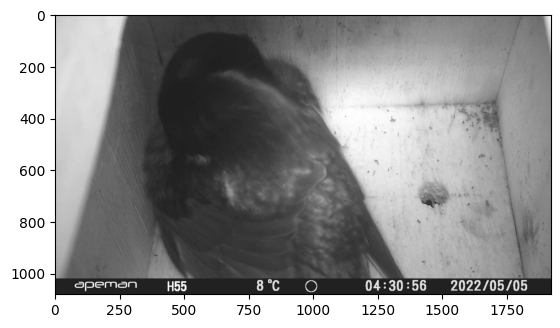

In [257]:
file_paths = get_file_paths('Box #30')
single_file_path = file_paths[11] #random video in this box

video_capture = cv2.VideoCapture(single_file_path)
success,single_frame = video_capture.read()

plt.imshow(single_frame)

## Configure screen capture crop areas

The tesseract library can search an entire image for any text but to make things easier I'll crop the specific areas of the frame that contain the text I'm looking for.

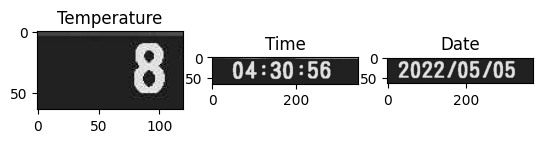

In [258]:
# Cropping areas of single frame of video. Values found through trail and error
temperature = single_frame[-64:, 700:820]
time = single_frame[-64:, 1150:1500]
date = single_frame[-64:, 1500:-50]

# Display cropped image
plt.subplot(1,3,1)
plt.title("Temperature")
plt.imshow(temperature)

plt.subplot(1,3,2)
plt.title("Time")
plt.imshow(time)

plt.subplot(1,3,3)
plt.title("Date")
plt.imshow(date)

## Scale and stretch images

Through some trial and error, I found that tesseract gave better results if the images were scaled up and slightly stretched horizontally. This helped with differentiating between "7" and "1" for example.

In [259]:
def scale_and_stretch_image(img):
    scale_percent = 150 # percent of original size
    stretch_percent = 130
    width = int(img.shape[1] * (scale_percent / 100) * (stretch_percent / 100) )
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)


    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

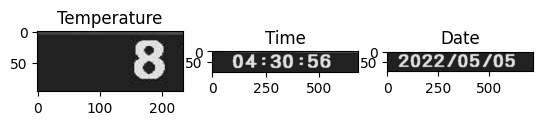

In [260]:
# Display cropped image
plt.subplot(1,3,1)
plt.title("Temperature")
plt.imshow(scale_and_stretch_image(temperature))

plt.subplot(1,3,2)
plt.title("Time")
plt.imshow(scale_and_stretch_image(time))

plt.subplot(1,3,3)
plt.title("Date")
plt.imshow(scale_and_stretch_image(date))

## get_text(file_path)

This function uses tesseract library to extract the text from the cropped areas of the frame. Will be used in the following cell to loop through all the videos in a box.

In [261]:
def get_text(file_path):
    temperature_text = ''
    time_text = ''
    date_text = ''
    
    video_capture = cv2.VideoCapture(file_path)

    success,single_frame = video_capture.read()
    if not success:
        print(f'Error on {file_path}')
        return temperature_text, time_text, date_text

    # Crop images using values found in previous cell
    temperature = single_frame[-60:, 700:820]
    time = single_frame[-60:, 1150:1500]
    date = single_frame[-60:, 1500:-50]

    # Scale and stretch images horizontally for better results from tesseract
    temperature = scale_and_stretch_image(temperature)
    time = scale_and_stretch_image(time)
    date = scale_and_stretch_image(date)

    # Get text using pytesseract
    temperature_text = pytesseract.image_to_string(temperature, config="--psm 7")
    time_text = pytesseract.image_to_string(time, config="--psm 7")
    date_text = pytesseract.image_to_string(date, config="--psm 7")

    return temperature_text.strip(), time_text.strip(), date_text.strip()

In [262]:
get_text(single_file_path)

('8', '04:30:56', '2022/05/05')

## build_dateframe(box)

Loops through all videos in a box and uses the get_text function from above to extract the required text. Saves the results to a csv file.

In [263]:
def build_dataframe(box):
    # initialize varialbles    
    temperature_list = []
    time_list = []
    date_list = []
    count = 0
    
    # get file paths
    file_paths = get_file_paths(box)
        
    # loop through all the video files and get text
    for file in file_paths:
        count += 1
        
        # get text
        temperature_text, time_text, date_text = get_text(file)
        
        # display progress
        clear_output()
        print(f'{box} {count}/{len(file_paths)} Temperature = {temperature_text} Time = {time_text} Date = {date_text}', end='\r', flush=True)
       
        # append text to result lists
        temperature_list += [temperature_text]
        time_list += [time_text]
        date_list += [date_text]
                
    # Finally build dateframe and save to csv
    df = pd.DataFrame({'file': file_paths,
                           'temp': temperature_list,
                           'time': time_list,
                           'date': date_list})
    df.to_csv(os.path.join(project_directory, f'{box}_filled.csv'), index=False)   
    
        

In [264]:
box = 'Box #30'
build_dataframe(box)